In [9]:
from DatasetManager import *
from model import *
from utils import *

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model


In [ ]:
# Check available GPUs
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(f"{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
else:
    print("No GPU devices found.")

In [10]:
base_dir = os.getcwd()
biosample_filename = 'biosample.csv'
genotype_filename = 'genotype.csv'
output_filename = 'mapped_file.csv'
final_df, mapped_file = join_and_save_csv(base_dir, biosample_filename, genotype_filename, output_filename)

In [11]:
final_df

,Biosample,genotype,Experimental_Group
0,1,Spry4+/+,Control
1,10000,Spry4+/+,Control
2,1135,Spry4+/+,Control
3,1138,Spry4+/+,Control
4,1124,Spry2+/+,Control
5,1125,Spry2+/+,Control
6,1126,Spry2+/+,Control
7,113,Spry2+/-,Experiment
8,1176,Spry2+/-,Experiment
9,1177,Spry2+/-,Experiment


In [12]:
mapped_file

'Musimages/ml_dataset/data/mapped_file.csv'

In [3]:
# Prepare datasets
base_dir = os.getcwd()
dataset_manager = DatasetManager(base_dir)

# Dictionary to hold paths to CSV files and their corresponding directories
csv_paths = {
    'train': ('data/mapped_file.csv', 'train'),
    'val': ('validation.csv', 'val'),
    'test': ('test.csv', 'test')
}

# Dictionary to store datasets for train, validation, and test
datasets = {}

# Augmentation settings for each dataset
augmentation_types = {
    'train': None,   # For example, applying 'rotation' or 'brightness' augmentation
    'val': None,  
    'test': None     # No augmentation for testing data
}


for key, (csv_file, folder) in csv_paths.items():
    image_paths, labels = dataset_manager.load_images_and_labels(csv_file, folder)
    datasets[key] = dataset_manager.prepare_dataset(
        image_paths, 
        labels, 
        batch_size=6, 
        shuffle=(key == 'train'), 
        augment_type=augmentation_types[key]
    )

train_dataset = datasets['train']
validation_dataset = datasets['val']
test_dataset = datasets['test']

In [4]:
#test if dataset shapes are correct
for images, labels in test_dataset.take(1):  # Taking just one batch for demonstration
    print("Images shape:", images.shape)  # Should be (batch_size, 256, 256, 256, 1)
    print("Labels shape:", labels.shape)  # Should be (batch_size,)
    print("Images dtype:", images.dtype)  # Should be float32
    print("Labels dtype:", labels.dtype)  # Should be int32 or similar depending on how labels are processed


/opt/anaconda3/lib/python3.11/site-packages/nibabel/minc2.py:68: UserWarning: Invalid spacing declaration: b'xspace'; assuming regular
  warnings.warn(f'Invalid spacing declaration: {spacing}; assuming regular')


Images shape: (6, 256, 256, 256, 1)
Labels shape: (6,)
Images dtype: <dtype: 'float32'>
Labels dtype: <dtype: 'int32'>


2024-04-23 18:18:31.425992: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [5]:
model_manager = ModelManager()


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [6]:
# Define callbacks and ModelCheckpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model_checkpoint = ModelCheckpoint(filepath=base_dir + '/best_model.keras', save_best_only=True)

history = model_manager.train(
    train_data=train_dataset,
    validation_data=validation_dataset,
    epochs=10,
    batch_size=6,
    callbacks=[early_stopping, model_checkpoint]
)


Epoch 1/10


2024-04-23 18:19:29.271230: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1 of 10
2024-04-23 18:19:29.271274: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40s/step - accuracy: 0.4667 - loss: 0.6027   Failed to process file Musimages/ml_dataset/val/6600.mnc: Unable to open file (truncated file: eof = 116391936, sblock->base_addr = 0, stored_eof = 278209322)Failed to process file Musimages/ml_dataset/val/3976.mnc: Unable to open file (truncated file: eof = 200278016, sblock->base_addr = 0, stored_eof = 259843214)

Failed to process file Musimages/ml_dataset/val/4437.mnc: Unable to open file (truncated file: eof = 153092096, sblock->base_addr = 0, stored_eof = 239807709)
2/2 ━━━━━━━━━━━━━━━━━━━━ 186s 69s/step - accuracy: 0.5111 - loss: 0.5724 - val_accuracy: 0.5000 - val_loss: 2.5851
Epoch 2/10


2024-04-23 18:22:24.540021: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1 of 10
2024-04-23 18:22:24.710192: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41s/step - accuracy: 0.7667 - loss: 3.2387   Failed to process file Musimages/ml_dataset/val/3976.mnc: Unable to open file (truncated file: eof = 200278016, sblock->base_addr = 0, stored_eof = 259843214)Failed to process file Musimages/ml_dataset/val/6600.mnc: Unable to open file (truncated file: eof = 116391936, sblock->base_addr = 0, stored_eof = 278209322)

Failed to process file Musimages/ml_dataset/val/4437.mnc: Unable to open file (truncated file: eof = 153092096, sblock->base_addr = 0, stored_eof = 239807709)
2/2 ━━━━━━━━━━━━━━━━━━━━ 176s 69s/step - accuracy: 0.7444 - loss: 3.0686 - val_accuracy: 0.8750 - val_loss: 0.6669
Epoch 3/10


2024-04-23 18:25:32.327098: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1 of 10
2024-04-23 18:25:32.327145: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40s/step - accuracy: 0.7667 - loss: 0.6743   Failed to process file Musimages/ml_dataset/val/4437.mnc: Unable to open file (truncated file: eof = 153092096, sblock->base_addr = 0, stored_eof = 239807709)Failed to process file Musimages/ml_dataset/val/6600.mnc: Unable to open file (truncated file: eof = 116391936, sblock->base_addr = 0, stored_eof = 278209322)

Failed to process file Musimages/ml_dataset/val/3976.mnc: Unable to open file (truncated file: eof = 200278016, sblock->base_addr = 0, stored_eof = 259843214)
2/2 ━━━━━━━━━━━━━━━━━━━━ 187s 70s/step - accuracy: 0.7444 - loss: 0.6764 - val_accuracy: 0.5000 - val_loss: 0.6947
Epoch 4/10


2024-04-23 18:28:18.150821: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1 of 10
2024-04-23 18:28:35.752844: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2 of 10
2024-04-23 18:28:36.811743: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39s/step - accuracy: 0.3167 - loss: 0.6945   Failed to process file Musimages/ml_dataset/val/6600.mnc: Unable to open file (truncated file: eof = 116391936, sblock->base_addr = 0, stored_eof = 278209322)Failed to process file Musimages/ml_dataset/val/3976.mnc: Unable to open file (truncated file: eof = 200278016, sblock->base_addr = 0, stored_eof = 259843214)

Failed to process file Musimages/ml_dataset/val/4437.mnc: Unable to open file (truncated file: eof = 153092096, sblock->base_addr = 0, stored_eof = 239807709)
2/2 ━━━━━━━━━━━━━━━━━━━━ 181s 67s/step - accuracy: 0.3111 - loss: 0.6944 - val_accuracy: 0.5000 - val_loss: 0.6906
Epoch 5/10


2024-04-23 18:31:39.926228: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1 of 10
2024-04-23 18:31:40.467428: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39s/step - accuracy: 0.7667 - loss: 0.6894   Failed to process file Musimages/ml_dataset/val/6600.mnc: Unable to open file (truncated file: eof = 116391936, sblock->base_addr = 0, stored_eof = 278209322)
Failed to process file Musimages/ml_dataset/val/4437.mnc: Unable to open file (truncated file: eof = 153092096, sblock->base_addr = 0, stored_eof = 239807709)
Failed to process file Musimages/ml_dataset/val/3976.mnc: Unable to open file (truncated file: eof = 200278016, sblock->base_addr = 0, stored_eof = 259843214)
2/2 ━━━━━━━━━━━━━━━━━━━━ 183s 67s/step - accuracy: 0.7444 - loss: 0.6898 - val_accuracy: 0.5000 - val_loss: 0.6837
Epoch 6/10


2024-04-23 18:34:27.110477: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1 of 10
2024-04-23 18:34:35.473565: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39s/step - accuracy: 0.6833 - loss: 0.6805   Failed to process file Musimages/ml_dataset/val/3976.mnc: Unable to open file (truncated file: eof = 200278016, sblock->base_addr = 0, stored_eof = 259843214)
Failed to process file Musimages/ml_dataset/val/4437.mnc: Unable to open file (truncated file: eof = 153092096, sblock->base_addr = 0, stored_eof = 239807709)
Failed to process file Musimages/ml_dataset/val/6600.mnc: Unable to open file (truncated file: eof = 116391936, sblock->base_addr = 0, stored_eof = 278209322)
2/2 ━━━━━━━━━━━━━━━━━━━━ 175s 67s/step - accuracy: 0.6889 - loss: 0.6794 - val_accuracy: 0.5000 - val_loss: 0.6701
Epoch 7/10


2024-04-23 18:37:23.852943: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1 of 10
2024-04-23 18:37:30.089411: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40s/step - accuracy: 0.6833 - loss: 0.6634   Failed to process file Musimages/ml_dataset/val/6600.mnc: Unable to open file (truncated file: eof = 116391936, sblock->base_addr = 0, stored_eof = 278209322)Failed to process file Musimages/ml_dataset/val/4437.mnc: Unable to open file (truncated file: eof = 153092096, sblock->base_addr = 0, stored_eof = 239807709)

Failed to process file Musimages/ml_dataset/val/3976.mnc: Unable to open file (truncated file: eof = 200278016, sblock->base_addr = 0, stored_eof = 259843214)
2/2 ━━━━━━━━━━━━━━━━━━━━ 175s 67s/step - accuracy: 0.6889 - loss: 0.6609 - val_accuracy: 0.5000 - val_loss: 0.6288
Epoch 8/10


2024-04-23 18:40:30.002512: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1 of 10
2024-04-23 18:40:31.190762: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39s/step - accuracy: 0.7667 - loss: 0.6222   Failed to process file Musimages/ml_dataset/val/4437.mnc: Unable to open file (truncated file: eof = 153092096, sblock->base_addr = 0, stored_eof = 239807709)
Failed to process file Musimages/ml_dataset/val/3976.mnc: Unable to open file (truncated file: eof = 200278016, sblock->base_addr = 0, stored_eof = 259843214)
Failed to process file Musimages/ml_dataset/val/6600.mnc: Unable to open file (truncated file: eof = 116391936, sblock->base_addr = 0, stored_eof = 278209322)
2/2 ━━━━━━━━━━━━━━━━━━━━ 180s 67s/step - accuracy: 0.7444 - loss: 0.6356 - val_accuracy: 0.5000 - val_loss: 0.5956
Epoch 9/10


2024-04-23 18:43:24.080814: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1 of 10
2024-04-23 18:43:27.386372: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39s/step - accuracy: 0.7667 - loss: 0.5792   Failed to process file Musimages/ml_dataset/val/4437.mnc: Unable to open file (truncated file: eof = 153092096, sblock->base_addr = 0, stored_eof = 239807709)
Failed to process file Musimages/ml_dataset/val/6600.mnc: Unable to open file (truncated file: eof = 116391936, sblock->base_addr = 0, stored_eof = 278209322)
Failed to process file Musimages/ml_dataset/val/3976.mnc: Unable to open file (truncated file: eof = 200278016, sblock->base_addr = 0, stored_eof = 259843214)
2/2 ━━━━━━━━━━━━━━━━━━━━ 176s 67s/step - accuracy: 0.7444 - loss: 0.6031 - val_accuracy: 0.5000 - val_loss: 0.6063
Epoch 10/10


2024-04-23 18:46:16.589188: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1 of 10
2024-04-23 18:46:22.306405: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40s/step - accuracy: 0.7667 - loss: 0.5653   Failed to process file Musimages/ml_dataset/val/6600.mnc: Unable to open file (truncated file: eof = 116391936, sblock->base_addr = 0, stored_eof = 278209322)
Failed to process file Musimages/ml_dataset/val/4437.mnc: Unable to open file (truncated file: eof = 153092096, sblock->base_addr = 0, stored_eof = 239807709)
Failed to process file Musimages/ml_dataset/val/3976.mnc: Unable to open file (truncated file: eof = 200278016, sblock->base_addr = 0, stored_eof = 259843214)
2/2 ━━━━━━━━━━━━━━━━━━━━ 176s 67s/step - accuracy: 0.7444 - loss: 0.5911 - val_accuracy: 0.5000 - val_loss: 0.6226


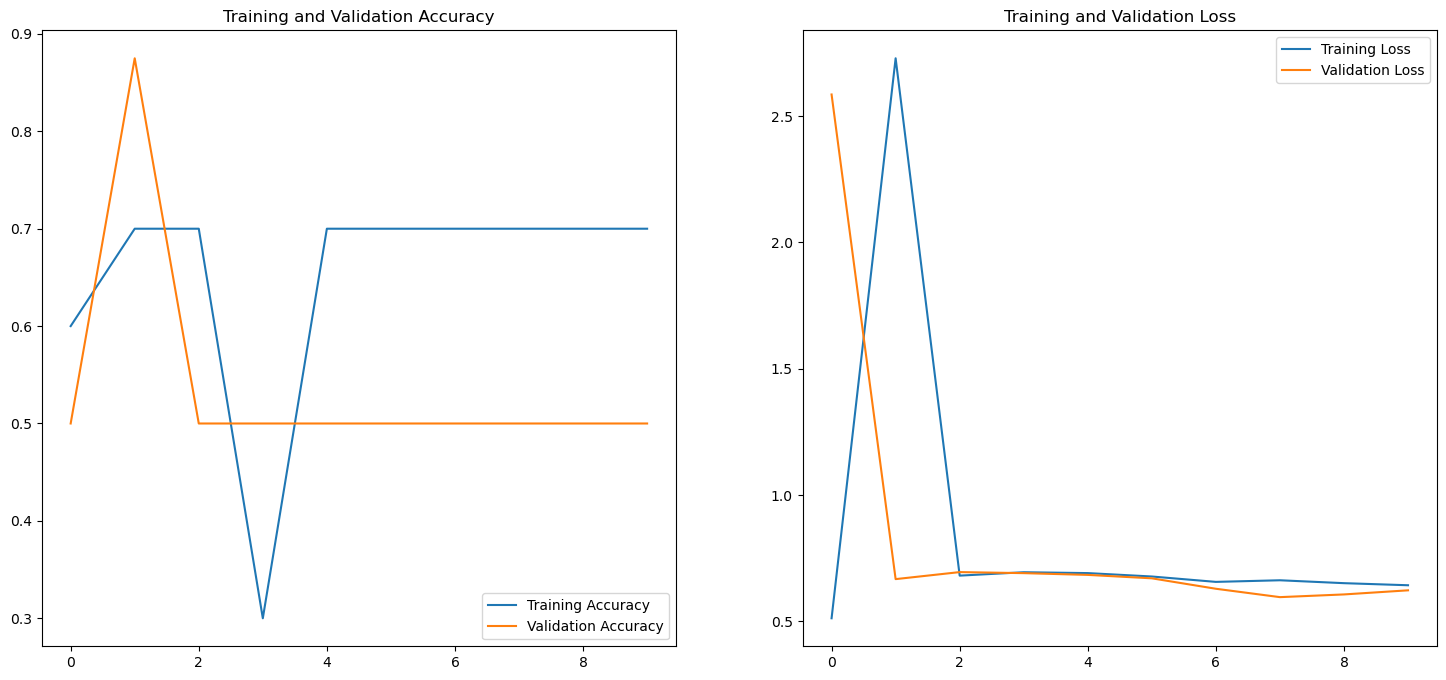

In [7]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = len(acc)
epochs_range = range(epochs)
plt.figure(figsize=(18, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [6]:
model_path = 'Musimages/ml_dataset/best_model.keras'

# Load the model
model_manager = load_model(model_path)


In [8]:
# Evaluate the model on test data
test_loss, test_accuracy = model_manager.evaluate(test_dataset)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.6111 - loss: 0.6402
Test Loss: 0.5671607851982117, Test Accuracy: 0.6666666865348816
Test Loss: 0.5671607851982117, Test Accuracy: 0.6666666865348816


In [ ]:
# Optionally, make predictions
# predictions = model_manager.predict(new_data)  # Assume new_data is ready